In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import umap
import hdbscan

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
data = pd.read_csv('CPS.csv')

In [4]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    'HUFINAL': 'interview_outcome',
    'hrnumhou': 'household_members',  # Number of members in a household
    'hefaminc' : 'family_income',

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for second job 
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'prtage': 'age', 
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

In [5]:
# Filter the dataset to keep only the selected columns, verifying they exist
data = data[[col for col in selected_columns if col in data.columns]].rename(columns=selected_columns)


In [6]:
# Replace NaN values with -1
data.fillna(-1, inplace=True)

In [7]:
# Impute -1 in Family income with weekly earning values when family income is -1
# Define the mapping from weekly earnings to family income categories
def earnings_to_income_category(weekly_earnings):
    annual_earnings = weekly_earnings * 52  # Convert weekly to annual

    # Map annual earnings to the provided categories
    if annual_earnings < 5000:
        return 1
    elif 5000 <= annual_earnings < 7500:
        return 2
    elif 7500 <= annual_earnings < 10000:
        return 3
    elif 10000 <= annual_earnings < 12500:
        return 4
    elif 12500 <= annual_earnings < 15000:
        return 5
    elif 15000 <= annual_earnings < 20000:
        return 6
    elif 20000 <= annual_earnings < 25000:
        return 7
    elif 25000 <= annual_earnings < 30000:
        return 8
    elif 30000 <= annual_earnings < 35000:
        return 9
    elif 35000 <= annual_earnings < 40000:
        return 10
    elif 40000 <= annual_earnings < 50000:
        return 11
    elif 50000 <= annual_earnings < 60000:
        return 12
    elif 60000 <= annual_earnings < 75000:
        return 13
    elif 75000 <= annual_earnings < 100000:
        return 14
    elif 100000 <= annual_earnings < 150000:
        return 15
    elif 150000 <= annual_earnings:
        return 16

# Apply mapping for rows where family_income is -1 and weekly_earnings is not -1
data.loc[(data['weekly_earnings'] != -1) & (data['family_income'] == -1), 'family_income'] = data['weekly_earnings'].apply(earnings_to_income_category)

In [8]:
data = data.loc[data['education_level'] != -1]

In [9]:
data = data.loc[data['family_income'] != -1]

In [10]:
data.shape

(82667, 26)

In [11]:
data = data.copy()

In [12]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

In [13]:
correlation_matrix

,interview_outcome,household_members,family_income,highest_level_of_school,education_level,professional_certification1,cert_issued_by_state_or_gov,is_cert_required,employment_status,primary_industry_code_job1,...,total_hours_worked,weekly_earnings,race,age,gender,citizenship_status,state_code,usual_hours_worked,reason_for_unemployment,health_status_impacting_work
interview_outcome,1.000000,0.027105,-0.015146,0.003417,-0.026438,0.006064,-0.006737,0.001616,-0.004387,0.000869,...,-0.028257,-0.062556,0.004591,-0.018359,0.002177,0.005848,0.027793,0.007226,-0.001657,-0.023937
household_members,0.027105,1.000000,0.204589,0.174595,-0.169309,-0.004522,-0.006760,0.006482,-0.021339,0.082688,...,-0.003228,0.010456,0.088497,-0.407325,-0.018770,0.146778,-0.026164,0.074353,0.033859,-0.178044
family_income,-0.015146,0.204589,1.000000,0.001453,0.318603,-0.160664,0.167779,0.175480,-0.288591,0.246124,...,0.022323,0.133752,-0.002499,-0.124869,-0.045226,-0.062661,-0.011198,0.301804,-0.066036,0.086420
highest_level_of_school,0.003417,0.174595,0.001453,1.000000,-0.121777,0.066915,-0.063554,-0.059939,0.173405,-0.034081,...,-0.008185,-0.050078,0.050863,-0.401688,0.018718,-0.031336,-0.006443,-0.141917,0.024688,-0.041631
education_level,-0.026438,-0.169309,0.318603,-0.121777,1.000000,-0.247846,0.258628,0.240437,-0.265792,0.251568,...,0.028712,0.143390,-0.011241,0.129792,0.040962,-0.117484,-0.002542,0.234767,-0.041041,0.228850
professional_certification1,0.006064,-0.004522,-0.160664,0.066915,-0.247846,1.000000,-0.882132,-0.808346,0.269026,-0.232116,...,-0.024962,-0.090524,0.015721,0.048046,-0.005832,0.057595,-0.013076,-0.194928,0.026744,-0.064748
cert_issued_by_state_or_gov,-0.006737,-0.006760,0.167779,-0.063554,0.258628,-0.882132,1.000000,0.899973,-0.242396,0.282405,...,0.027634,0.107642,-0.018097,-0.029785,0.026475,-0.053020,0.017785,0.243241,-0.024284,0.070267
is_cert_required,0.001616,0.006482,0.175480,-0.059939,0.240437,-0.808346,0.899973,1.000000,-0.322148,0.349822,...,0.030314,0.126861,-0.016186,-0.065269,0.022780,-0.046984,0.019946,0.312753,-0.016641,0.060547
employment_status,-0.004387,-0.021339,-0.288591,0.173405,-0.265792,0.269026,-0.242396,-0.322148,1.000000,-0.758239,...,-0.029916,-0.221264,0.010202,0.172454,0.102018,-0.027474,-0.019385,-0.805259,0.055894,0.012694
primary_industry_code_job1,0.000869,0.082688,0.246124,-0.034081,0.251568,-0.232116,0.282405,0.349822,-0.758239,1.000000,...,0.029065,0.184132,0.024487,-0.282581,0.044193,0.018774,0.007230,0.644431,0.056923,-0.018987


In [14]:
# Set a high correlation threshold
high_corr_threshold = 0.98

# Find features with correlation greater than 0.98 or less than -0.98
highly_corr_vars = set()
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > high_corr_threshold or correlation_matrix.loc[row, col] < -high_corr_threshold) and row != col:
            highly_corr_vars.add(tuple(sorted((row, col))))

# Remove one of each pair 
columns_to_remove = set()
for var1, var2 in highly_corr_vars:
    # Add one of the pair to the set to be removed
    columns_to_remove.add(var1) 

# Drop the columns from the dataframe
data_reduced = data.drop(columns=columns_to_remove)

In [15]:
data

,interview_outcome,household_members,family_income,highest_level_of_school,education_level,professional_certification1,cert_issued_by_state_or_gov,is_cert_required,employment_status,primary_industry_code_job1,...,total_hours_worked,weekly_earnings,race,age,gender,citizenship_status,state_code,usual_hours_worked,reason_for_unemployment,health_status_impacting_work
0,201,3,12,-1.0,37.0,2.0,-1.0,-1.0,4.0,4.0,...,0,-1.0,1.0,35.0,2.0,1.0,1,-1.0,2.0,2.0
3,201,1,13,-1.0,40.0,2.0,-1.0,-1.0,1.0,18.0,...,0,115400.0,1.0,50.0,2.0,1.0,1,40.0,-1.0,2.0
4,201,2,16,-1.0,40.0,2.0,-1.0,-1.0,1.0,4.0,...,0,72000.0,1.0,58.0,1.0,1.0,1,40.0,-1.0,2.0
5,201,2,16,-1.0,40.0,1.0,1.0,1.0,1.0,11.0,...,0,132450.0,1.0,48.0,2.0,1.0,1,60.0,-1.0,2.0
6,201,2,15,-1.0,41.0,2.0,-1.0,-1.0,1.0,15.0,...,0,74000.0,1.0,47.0,2.0,1.0,1,40.0,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126695,201,4,15,-1.0,43.0,2.0,-1.0,-1.0,1.0,13.0,...,0,-1.0,1.0,59.0,1.0,1.0,53,40.0,-1.0,2.0
126696,201,4,15,2.0,40.0,2.0,-1.0,-1.0,7.0,-1.0,...,0,-1.0,1.0,18.0,1.0,1.0,53,-1.0,-1.0,2.0
126697,201,4,15,-1.0,35.0,2.0,-1.0,-1.0,7.0,-1.0,...,0,-1.0,1.0,15.0,2.0,1.0,53,-1.0,-1.0,2.0
126760,201,3,15,-1.0,43.0,2.0,-1.0,-1.0,1.0,21.0,...,0,141000.0,1.0,35.0,2.0,1.0,56,40.0,-1.0,2.0


In [16]:
data = data.loc[data['family_income'] != -1]

In [17]:
# Calculate the percentage of -1 for each column and drop columns with more than 40% -1 values
columns_to_drop = [column for column in data.columns if (data[column] == -1).sum() / len(data) > 0.40]

# Drop these columns
data.drop(columns=columns_to_drop, inplace=True)

# PCA

In [18]:
data_reduced = data.copy()

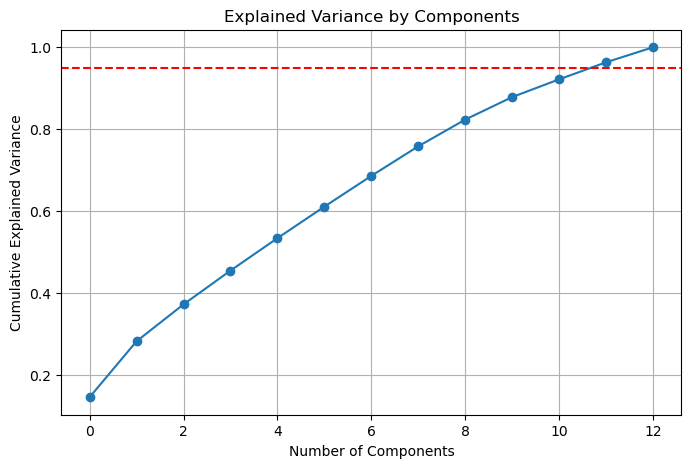

In [19]:
# Scaling the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data)

pca = PCA().fit(df_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # Line at 95% variance
plt.show()

Eigenvalues:
 [1.90505547 1.77393237 1.16892866 1.07158399 1.02763859 1.00047396
 0.97578597 0.93741594 0.84708786 0.71412029 0.56186992 0.54115706
 0.47510719]
Number of Components with Eigenvalues > 1: 6


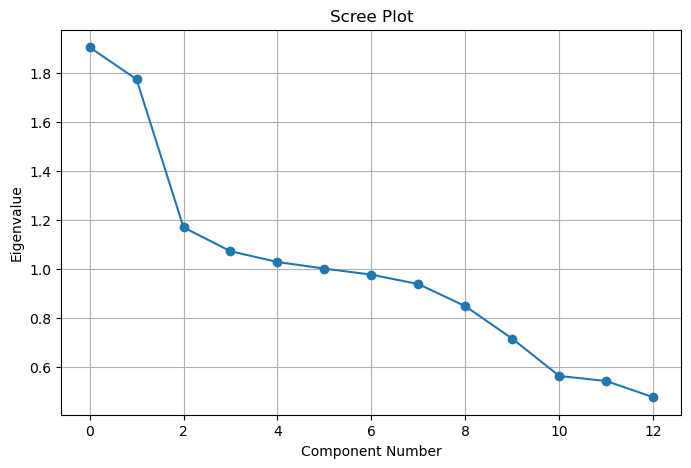

In [20]:
# Using the PCA fit from before
eigenvalues = pca.explained_variance_
print("Eigenvalues:\n", eigenvalues)
num_components_kaiser = np.sum(eigenvalues > 1)
print("Number of Components with Eigenvalues > 1:", num_components_kaiser)
plt.figure(figsize=(8, 5))
plt.plot(eigenvalues, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# UMAP

In [21]:
# Change float to category
categorical_columns = ['family_income', 'interview_outcome', 'education_level', 'professional_certification1', 'employment_status', 'race', 'gender', 'citizenship_status', 'state_code', 'health_status_impacting_work']
for col in categorical_columns:
    data[col] = data[col].astype('category')
    
int32_columns = ['household_members', 'total_hours_worked', 'age', 'state_code']
for col in int32_columns:
    data[col] = data[col].astype('int32')

In [22]:
# Define the preprocessing for numeric and categorical data
# Preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), int32_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ])

#  Preprocess the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data_transformed = pipeline.fit_transform(data_reduced)

In [23]:
data_transformed.shape

(82667, 138)

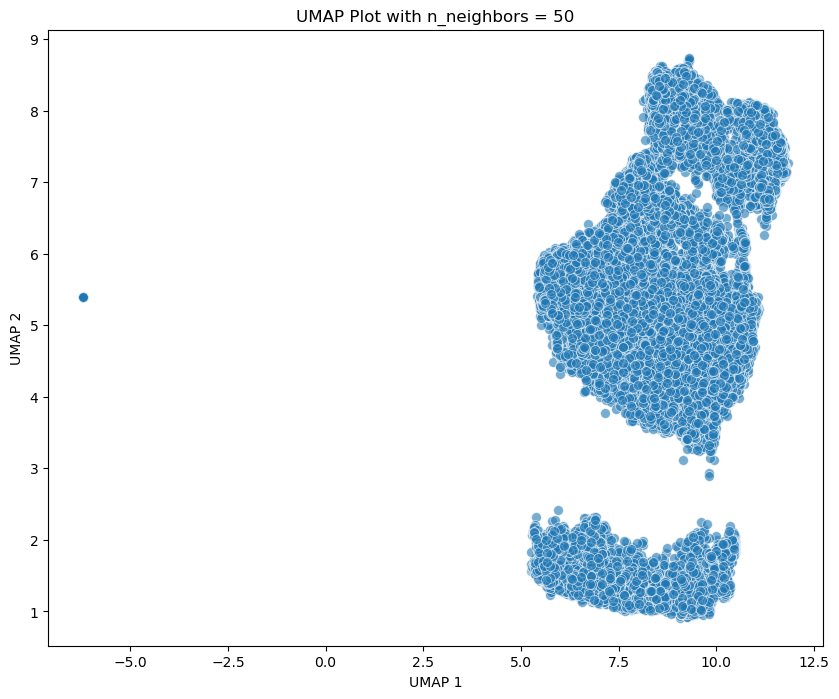

In [62]:
#50, 4
reducer = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.0)
embedding = reducer.fit_transform(data_transformed)

plt.figure(figsize=(10, 8))



sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=50, alpha=0.6, legend='full')

plt.title(f'UMAP Plot with n_neighbors = 50')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

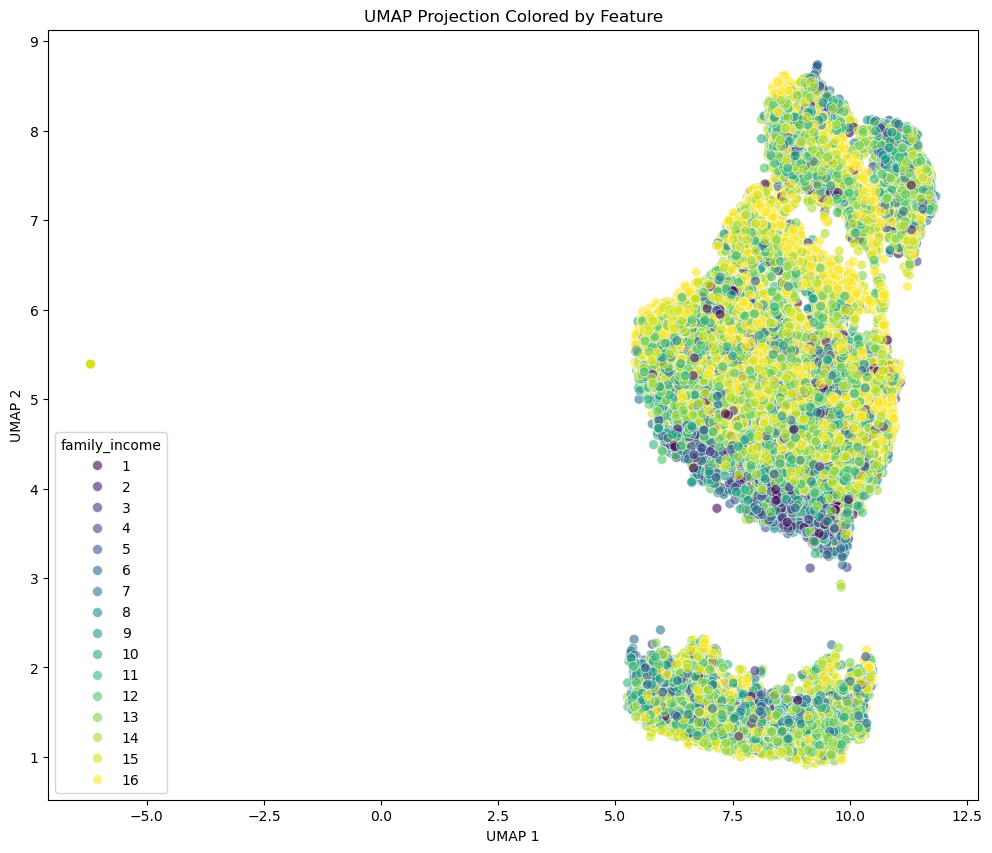

In [63]:
# Visualize a feature of interest in the original data
feature_of_interest = 'family_income'
plt.figure(figsize=(12, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=data_reduced[feature_of_interest], palette='viridis', s=50, alpha=0.6, legend='full')
plt.title('UMAP Projection Colored by Feature')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# HDBSCAN

In [64]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2000, min_samples=700, cluster_selection_epsilon=0.3)
cluster_labels = clusterer.fit_predict(embedding)

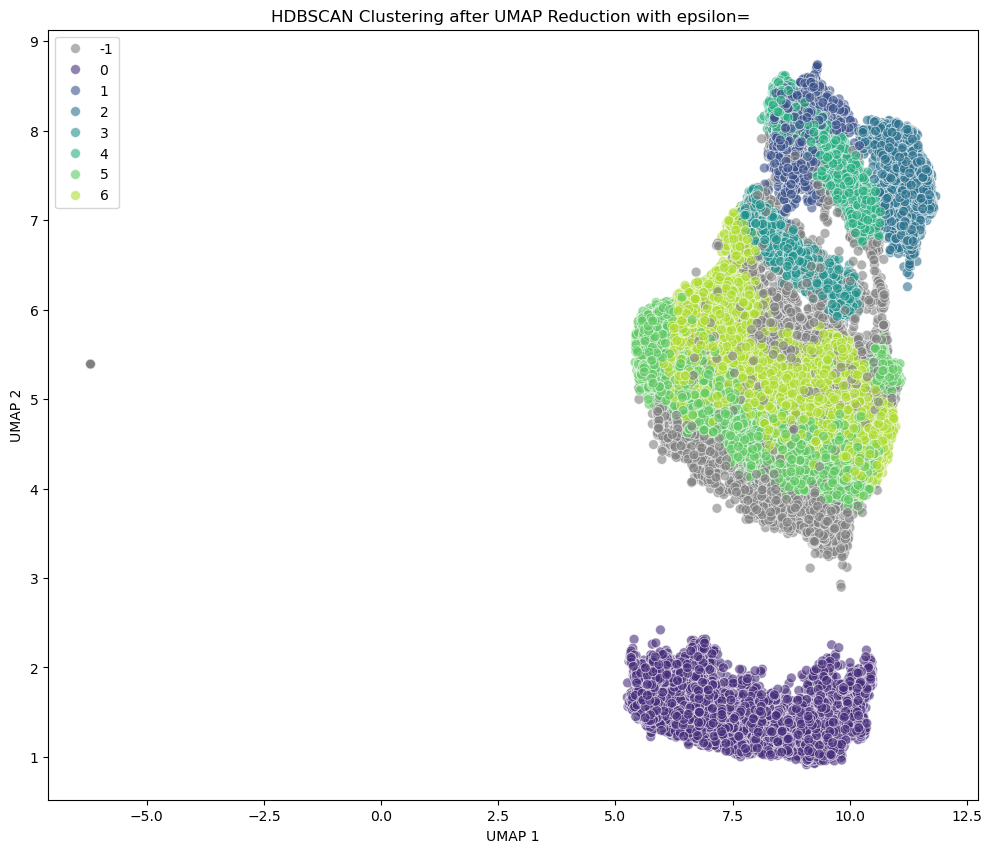

In [65]:
# Creating a custom palette:
# Set the color for noise points (-1) as grey, and use 'viridis' for all other valid clusters
unique_labels = np.unique(cluster_labels)
colors = sns.color_palette('viridis', n_colors=len(unique_labels) - (1 if -1 in unique_labels else 0))
palette = {label: colors.pop(0) for label in unique_labels if label != -1}
palette[-1] = 'grey'  # Assign grey to noise points

plt.figure(figsize=(12, 10))

# Create a scatter plot. 
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette=palette, s=50, alpha=0.6)

# Add a colorbar to the plot

# Add titles and labels
plt.title(f'HDBSCAN Clustering after UMAP Reduction with epsilon= ')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show the plot
plt.show()

C:\Users\almas\AppData\Local\Temp\ipykernel_14860\1562393187.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', len(unique_labels) - (1 if -1 in unique_labels else 0))


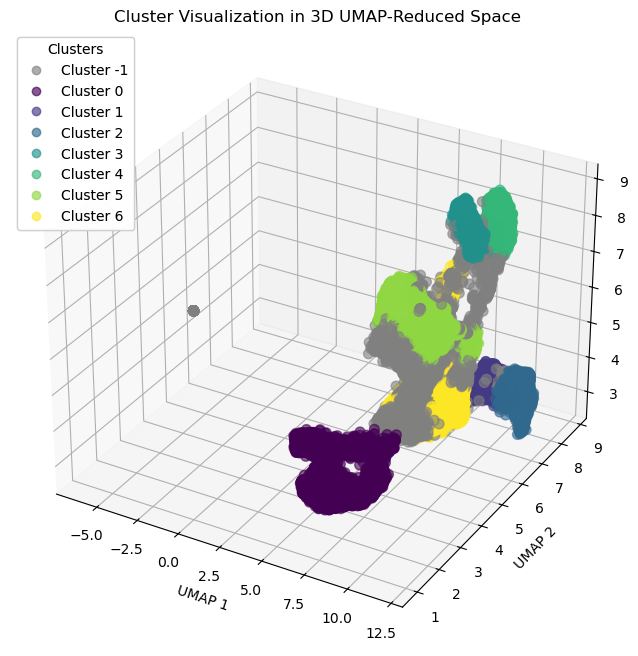

In [112]:
from matplotlib.colors import ListedColormap, Normalize


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Custom colormap setup
unique_labels = np.unique(cluster_labels)
viridis = plt.cm.get_cmap('viridis', len(unique_labels) - (1 if -1 in unique_labels else 0))
colors = [viridis(i) for i in range(viridis.N)]
if -1 in unique_labels:
    colors = ['grey'] + colors  # prepend grey for noise
custom_cmap = ListedColormap(colors)

# Scatter plot with custom colormap
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=cluster_labels, cmap=custom_cmap, s=50, alpha=0.6)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.title('Cluster Visualization in 3D UMAP-Reduced Space')

# Create a custom legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
labels = [f'Cluster {label}' if label != '-1' else 'Noise' for label in unique_labels]
legend = ax.legend(handles, labels, title="Clusters")

ax.add_artist(legend)
plt.show()

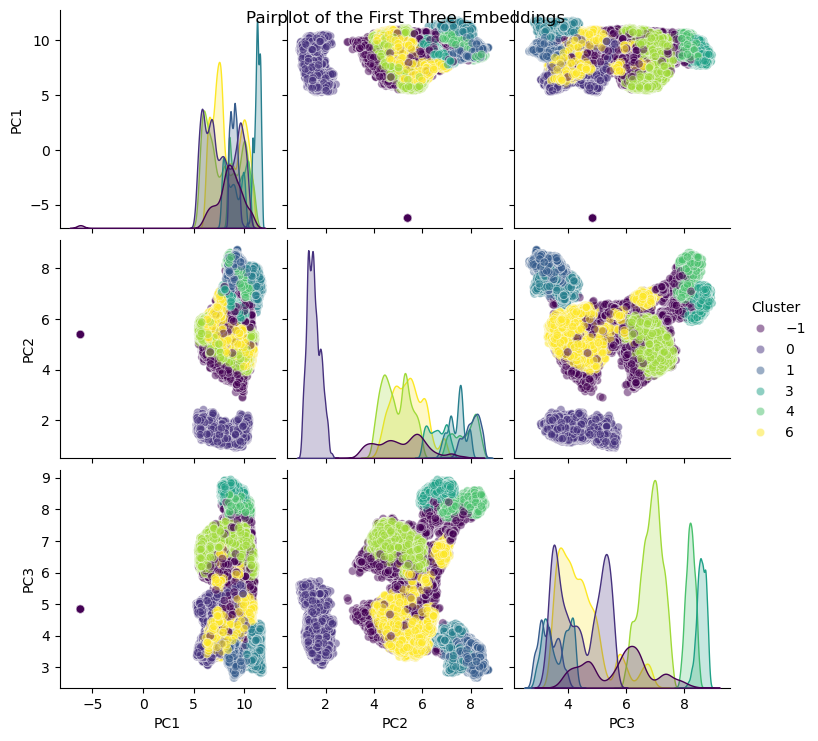

In [67]:
### Create a DataFrame with the first few principal components and cluster labels
UMAP_df = pd.DataFrame(data=embedding[:, :3], columns=[f'PC{i+1}' for i in range(3)])
UMAP_df['Cluster'] = cluster_labels

sns.pairplot(UMAP_df, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of the First Three Embeddings', verticalalignment='top')
plt.show()

# Evaluation

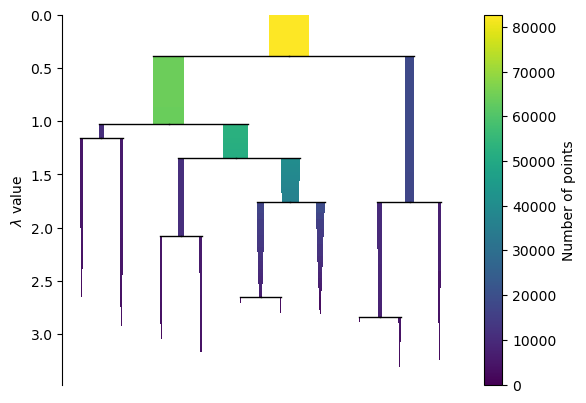

In [113]:
clusterer.condensed_tree_.plot()
plt.savefig('Tree.png')

In [69]:
data_reduced['Cluster_Labels'] = cluster_labels

In [70]:
from sklearn.metrics import silhouette_score

# Assume 'embedding' is the UMAP-reduced data and 'cluster_labels' are from HDBSCAN
# Note: It is crucial to exclude noise points (typically labeled as -1 in HDBSCAN)
filtered_labels = cluster_labels[cluster_labels != -1]
filtered_embedding = embedding[cluster_labels != -1]

# Calculate the silhouette score
score = silhouette_score(filtered_embedding, filtered_labels)
print('Silhouette Score: ', score)

Silhouette Score:  0.4165953


A silhouette score of 0.41 indicates great clustering, considering the complexity of the data.

# Exploring 

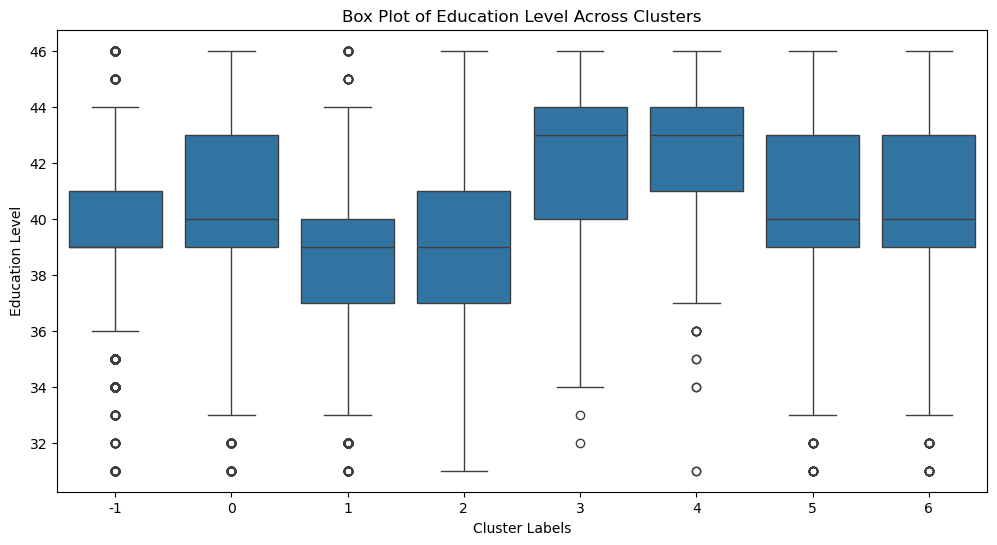

In [86]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Labels', y='education_level', data=data_reduced)
plt.title('Box Plot of Education Level Across Clusters')
plt.xlabel('Cluster Labels')
plt.ylabel('Education Level')
plt.show()

# Demographics

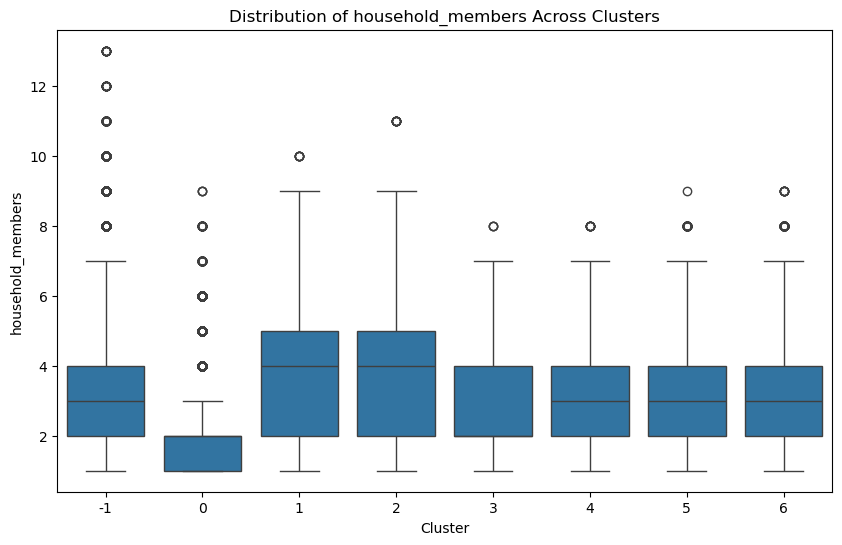

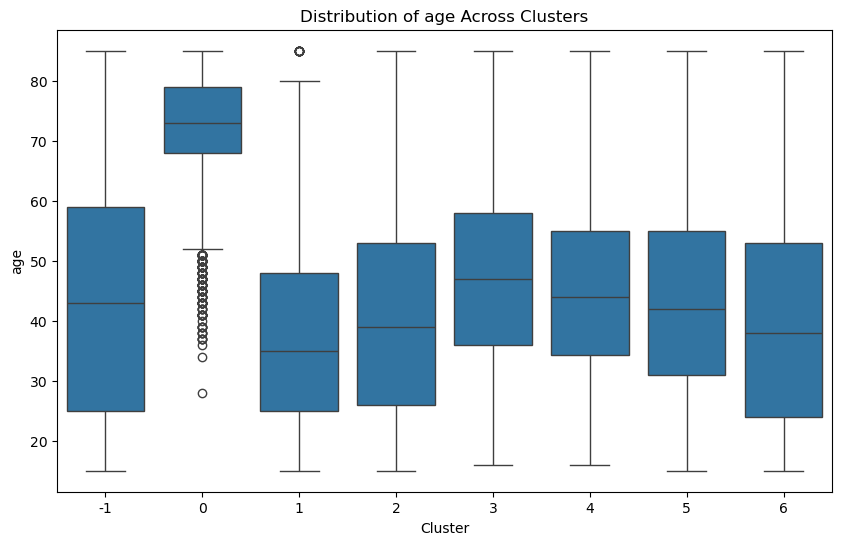

In [102]:
columns_to_visualize = ['household_members', 'age']

for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Labels', y=column, data=data_reduced)
    plt.title(f'Distribution of {column} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

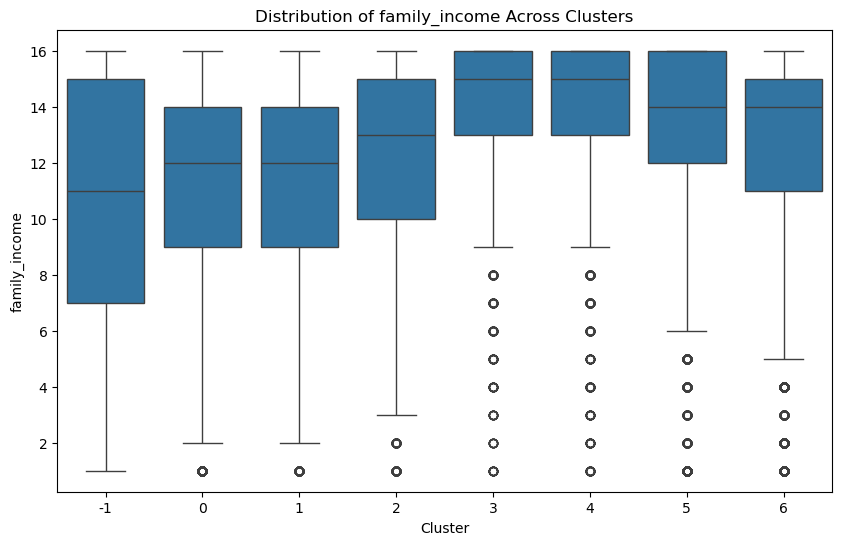

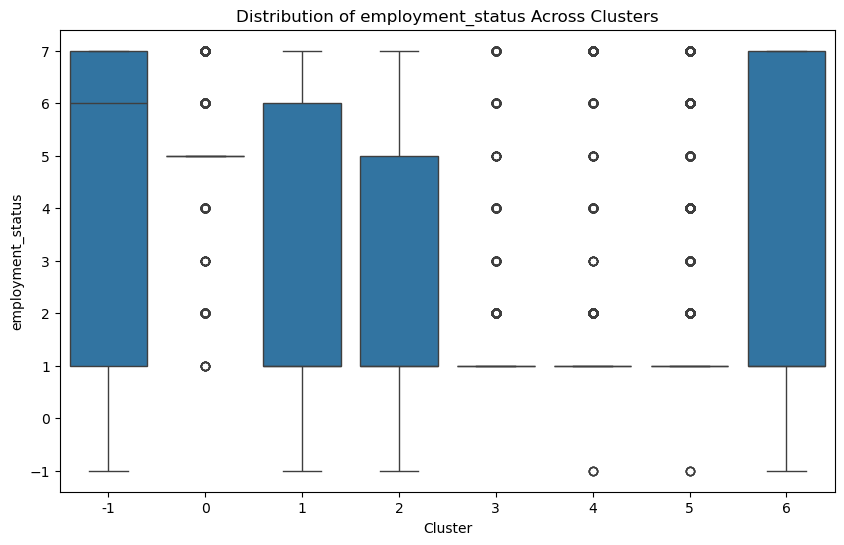

In [101]:
columns_to_visualize = ['family_income', 'employment_status']

for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Labels', y=column, data=data_reduced)
    plt.title(f'Distribution of {column} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

In [ ]:
columns_to_visualize = ['interview_outcome', 'state_code']

for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Labels', y=column, data=data_reduced)
    plt.title(f'Distribution of {column} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

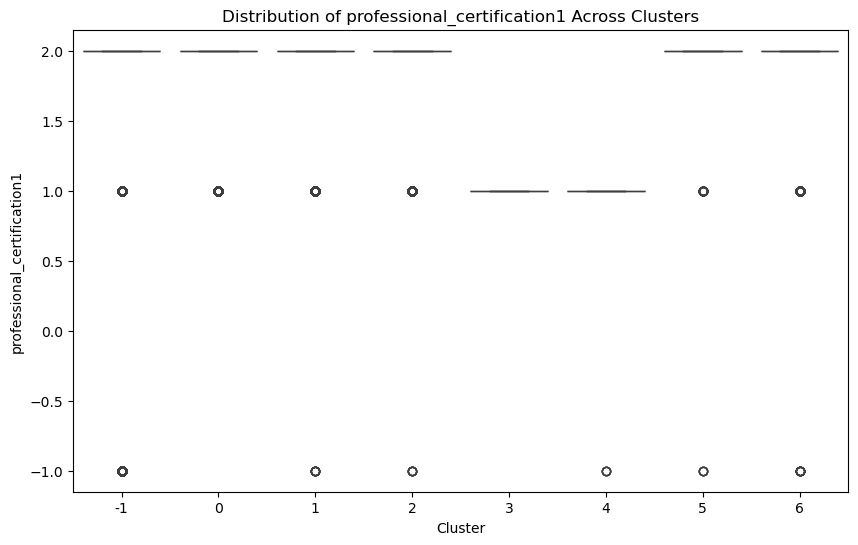

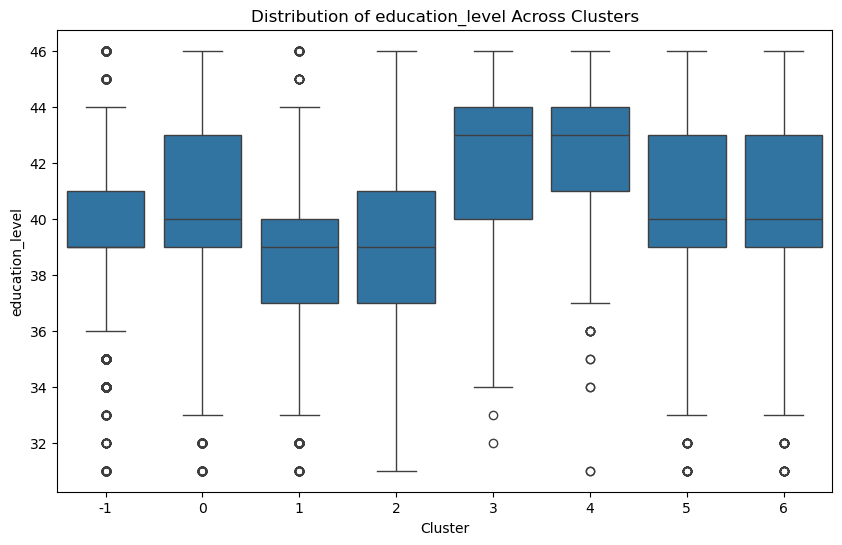

In [89]:
columns_to_visualize = ['professional_certification1', 'education_level']

for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Labels', y=column, data=data_reduced)
    plt.title(f'Distribution of {column} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

In [90]:
vis_data = data_reduced.copy()

In [92]:
# Given employment labels for direct mapping from the codes to their descriptions
employment_labels = [
    'EMPLOYED-AT WORK',
    'EMPLOYED-ABSENT',
    'UNEMPLOYED-ON LAYOFF',
    'UNEMPLOYED-LOOKING',
    'NOT IN LABOR FORCE-RETIRED',
    'NOT IN LABOR FORCE-DISABLED',
    'NOT IN LABOR FORCE-OTHER'
]

# Mapping from employment status codes to their descriptions
employment_status_descriptions = {i+1: label for i, label in enumerate(employment_labels)}

# Applying the mapping to the 'employment_status' column
vis_data['Employment_Status_Description'] = vis_data['employment_status'].map(employment_status_descriptions)

# Counting occurrences for each employment status description
employment_status_description_counts = vis_data['Employment_Status_Description'].value_counts()

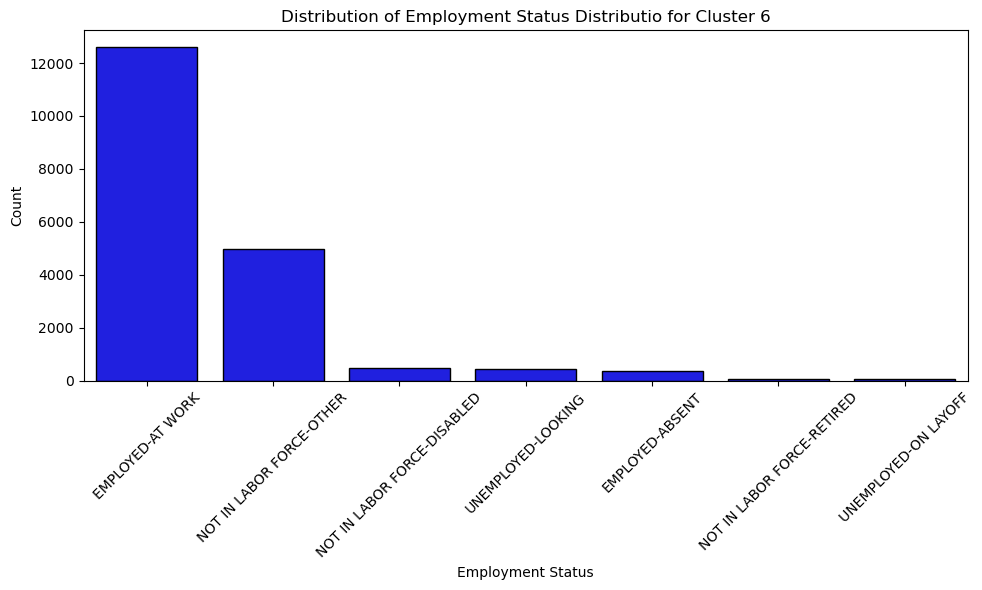

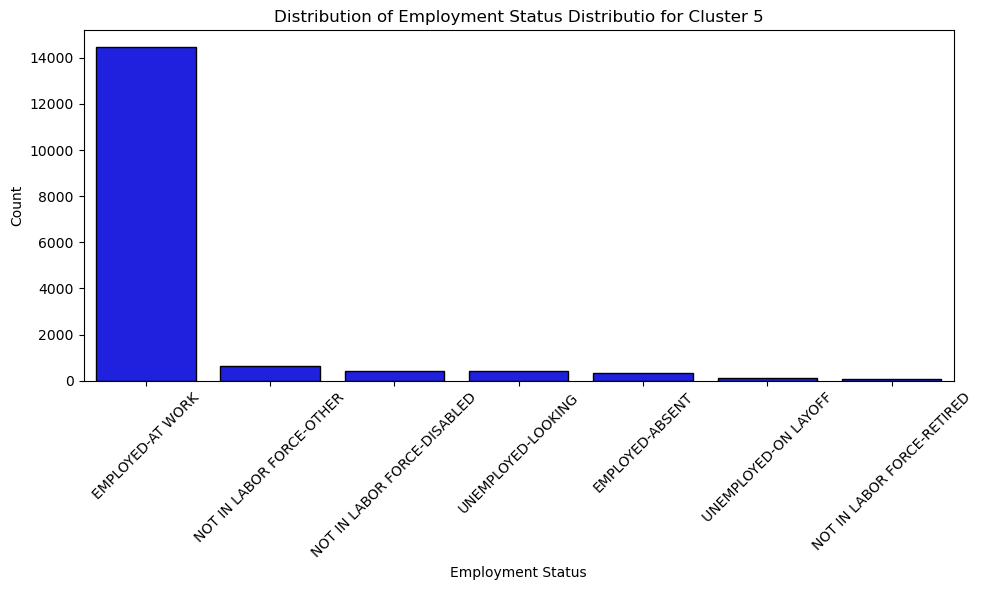

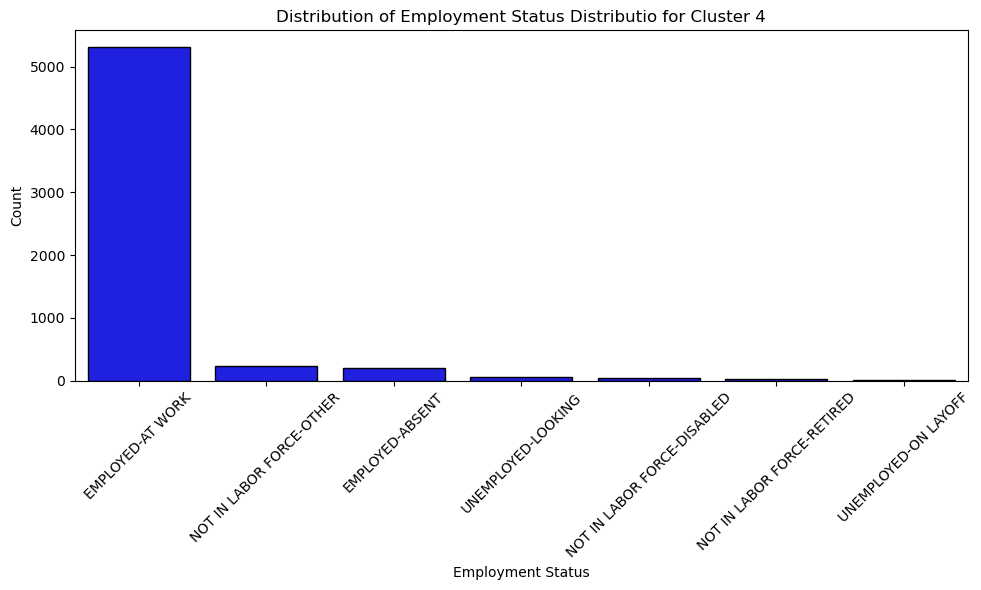

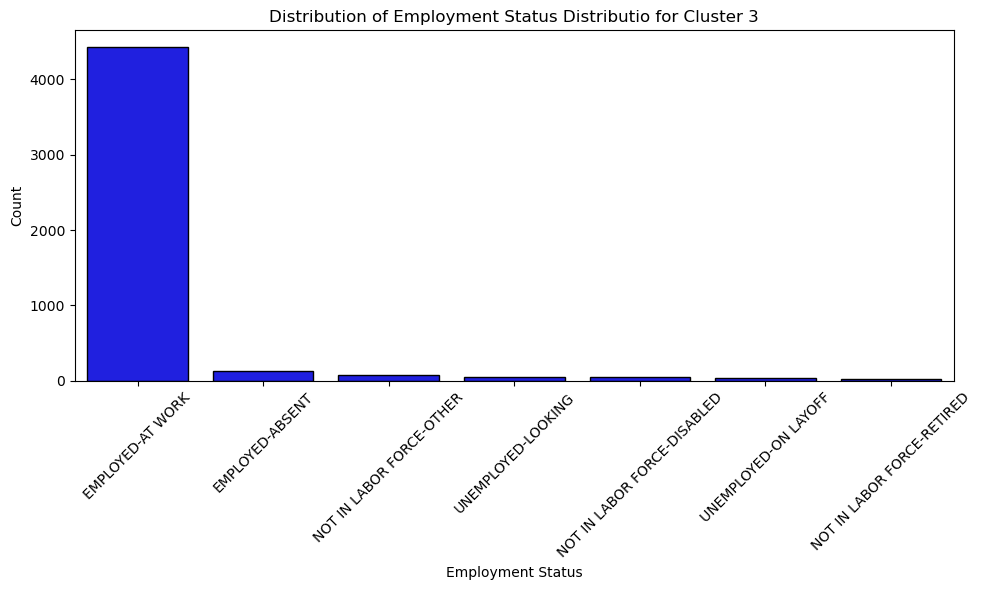

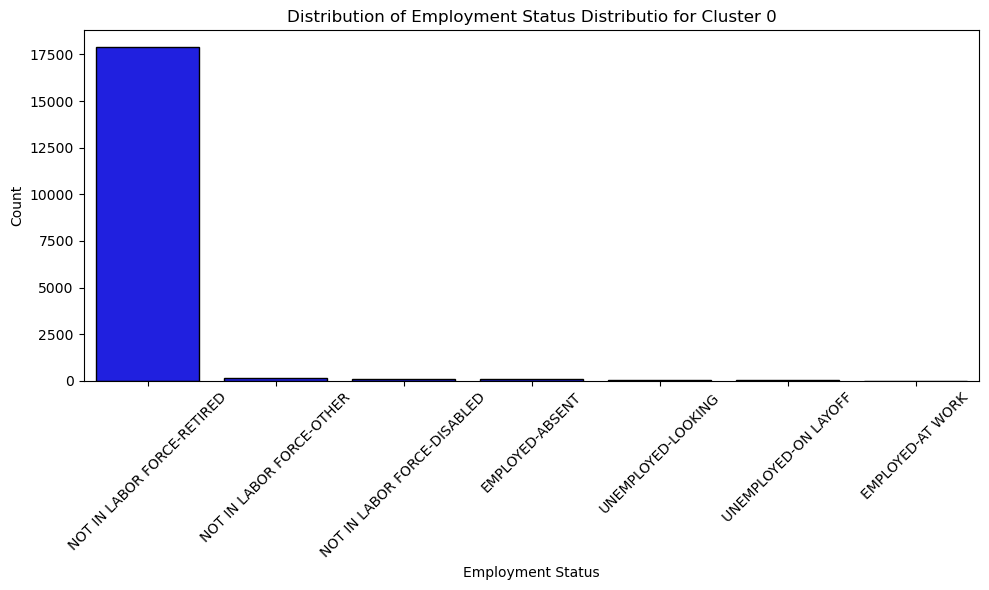

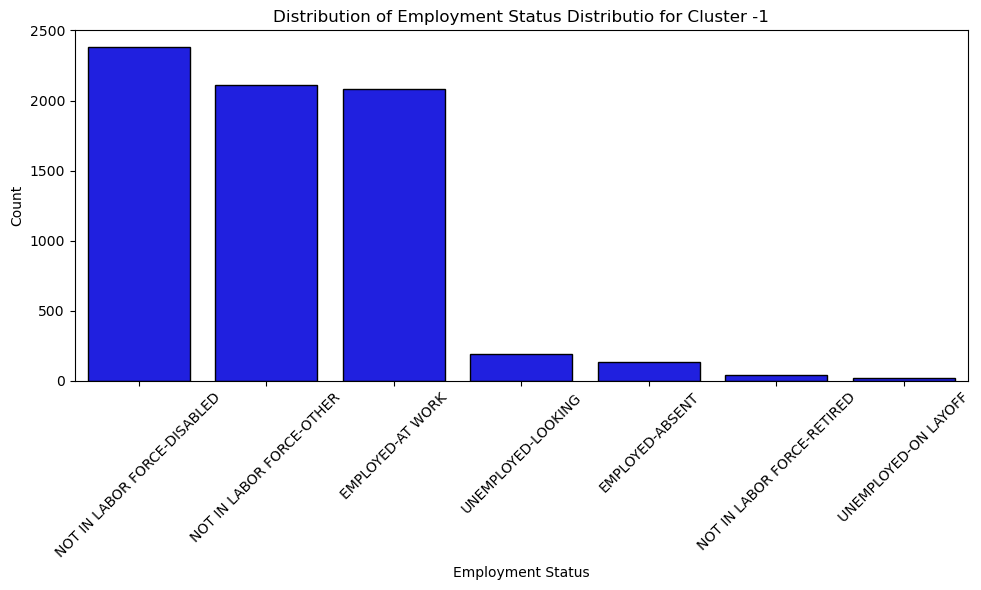

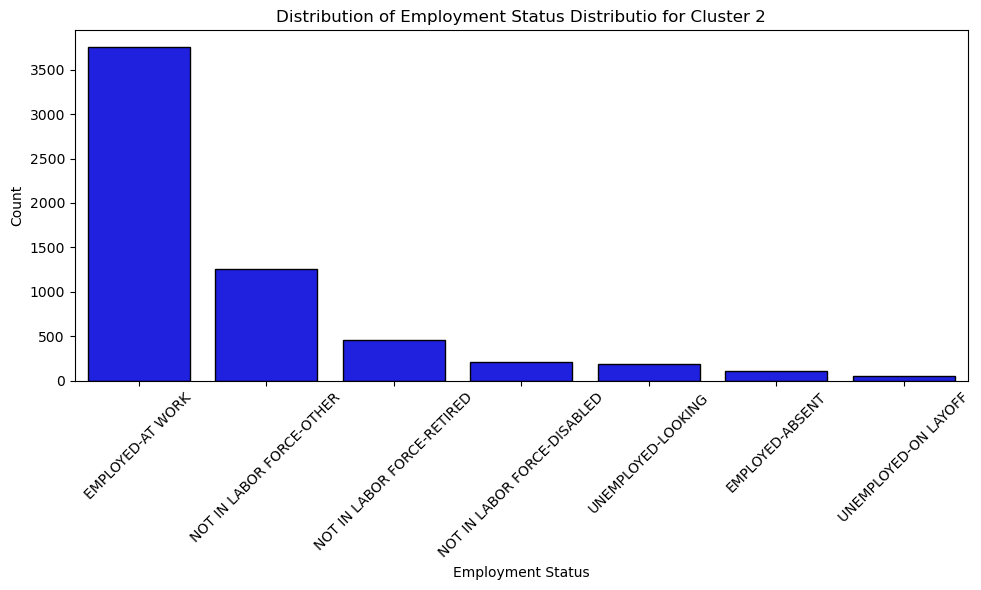

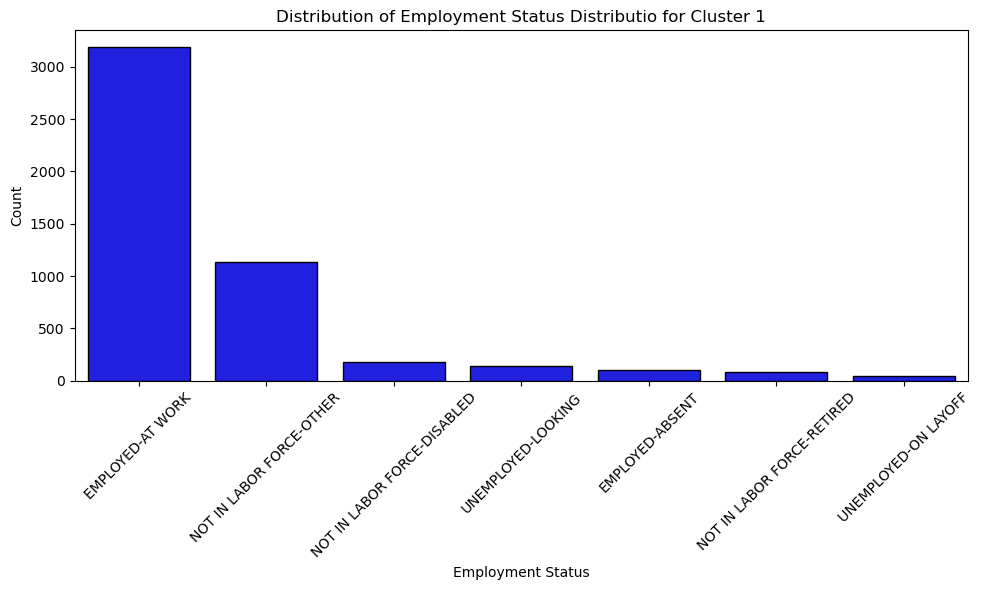

In [122]:
# Create a figure and axis for each unique cluster to visualize the counts of each employment status per cluster
clusters = data_reduced['Cluster_Labels'].unique()
for cluster in clusters:
    plt.figure(figsize=(10, 6))
    cluster_data = vis_data[vis_data['Cluster_Labels'] == cluster]
    employment_status_counts = cluster_data['Employment_Status_Description'].value_counts()
    
    sns.barplot(x=employment_status_counts.index, y=employment_status_counts.values, color='blue', edgecolor='black')
    plt.title(f'Distribution of Employment Status Distributio for Cluster {cluster}')
    plt.xlabel('Employment Status')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(F'ESDAllClusters{cluster}.png')

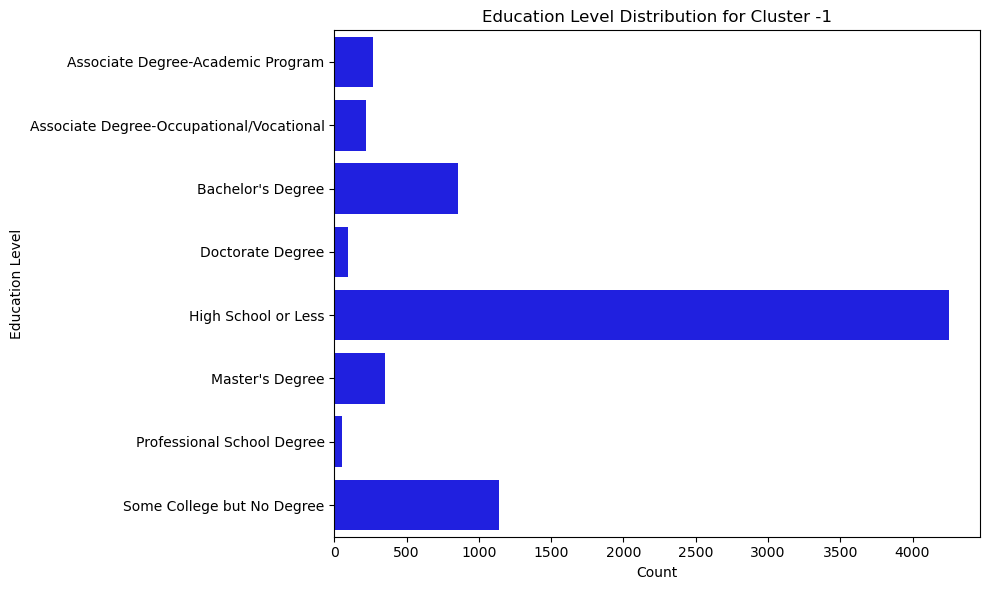

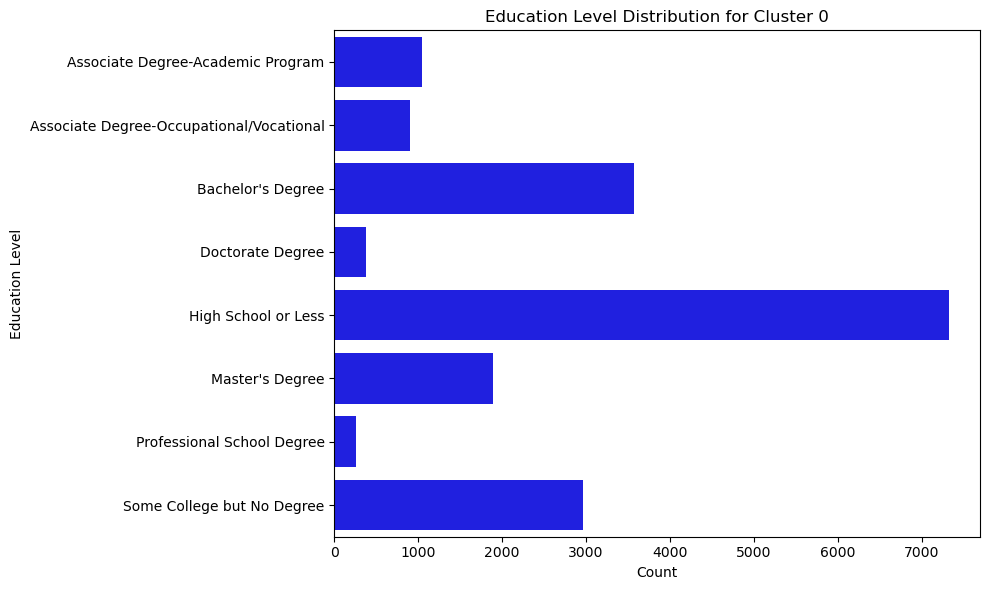

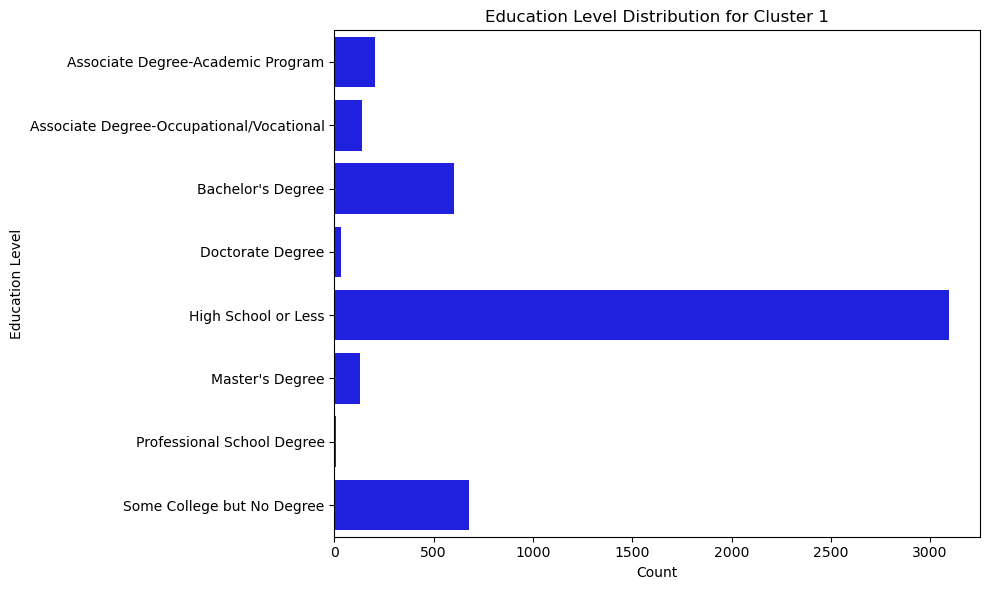

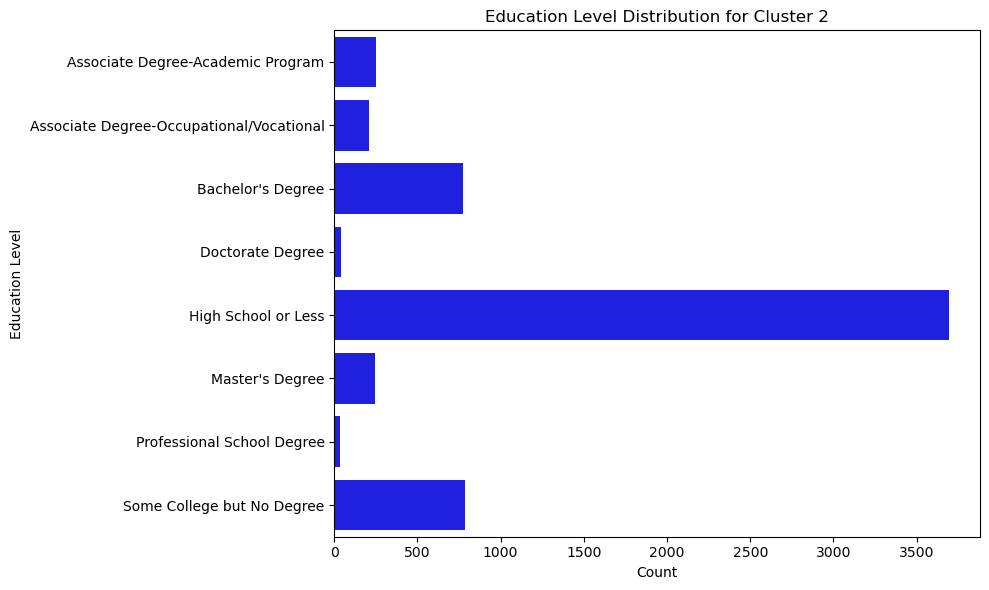

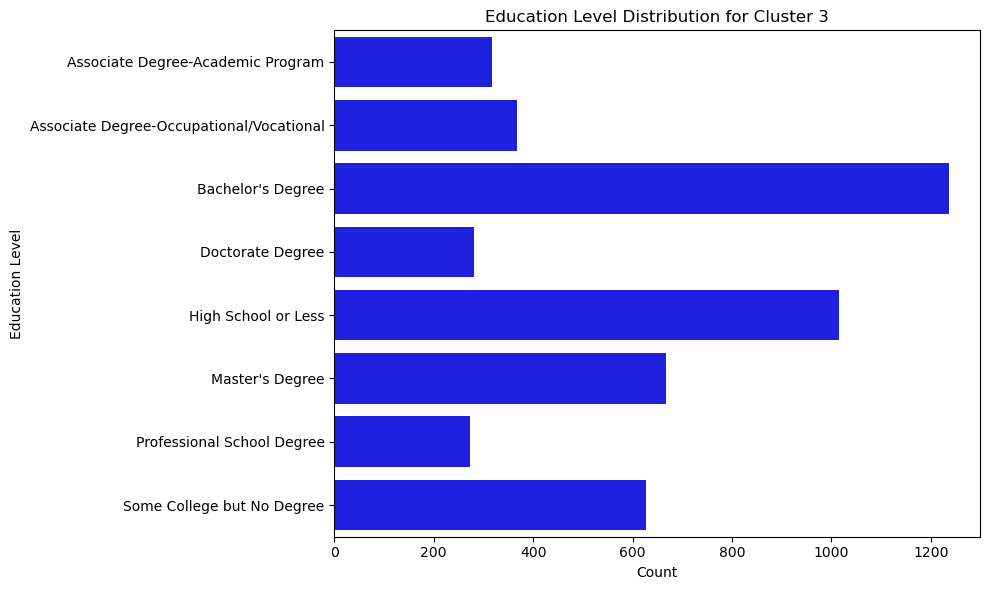

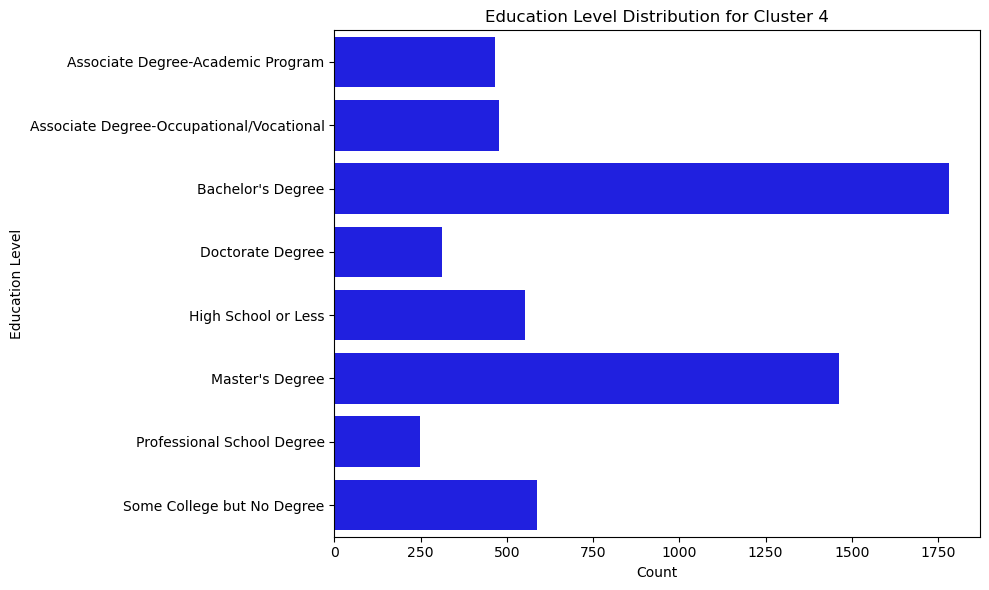

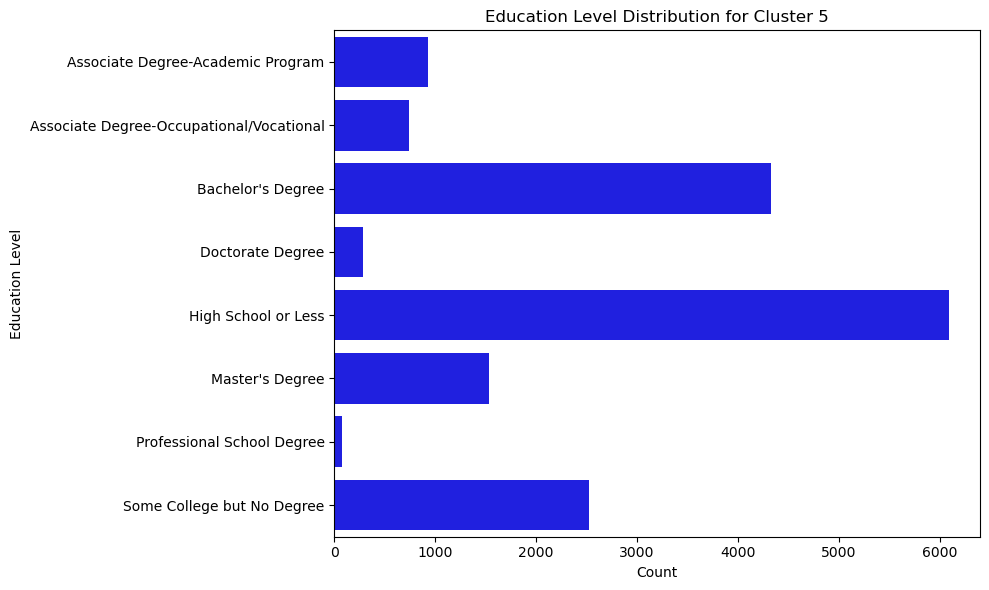

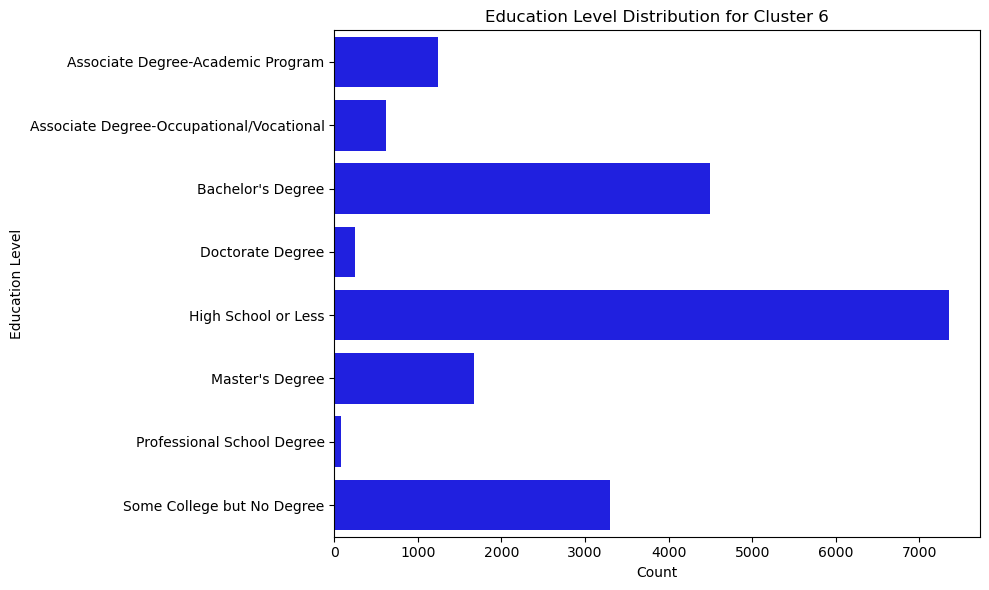

In [126]:
# Mapping the education levels to more generalized groups for clarity and aggregation
education_mapping = {
    31: 'High School or Less',
    32: 'High School or Less',
    33: 'High School or Less',
    34: 'High School or Less',
    35: 'High School or Less',
    36: 'High School or Less',
    37: 'High School or Less',
    38: 'High School or Less',
    39: 'High School or Less',
    40: 'Some College but No Degree',
    41: 'Associate Degree-Occupational/Vocational',
    42: 'Associate Degree-Academic Program',
    43: "Bachelor's Degree",
    44: "Master's Degree",
    45: 'Professional School Degree',
    46: 'Doctorate Degree'
}

# Applying the mapping to the 'education_level' column to create a new column for the aggregated groups
vis_data['Education_Level_Grouped'] = vis_data['education_level'].map(education_mapping)

# Counting the number of occurrences in each education level group
education_level_counts = vis_data['Education_Level_Grouped'].value_counts().sort_values()

# Creating a bar plot for the aggregated education levels
clusters = vis_data['Cluster_Labels'].unique()
for cluster in sorted(clusters):
    plt.figure(figsize=(10, 6))
    cluster_data = vis_data[data_reduced['Cluster_Labels'] == cluster]
    education_level_counts = cluster_data['Education_Level_Grouped'].value_counts().sort_index()

    sns.barplot(x=education_level_counts.values, y=education_level_counts.index, color='blue')
    plt.title(f'Education Level Distribution for Cluster {cluster}')
    plt.xlabel('Count')
    plt.ylabel('Education Level')
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

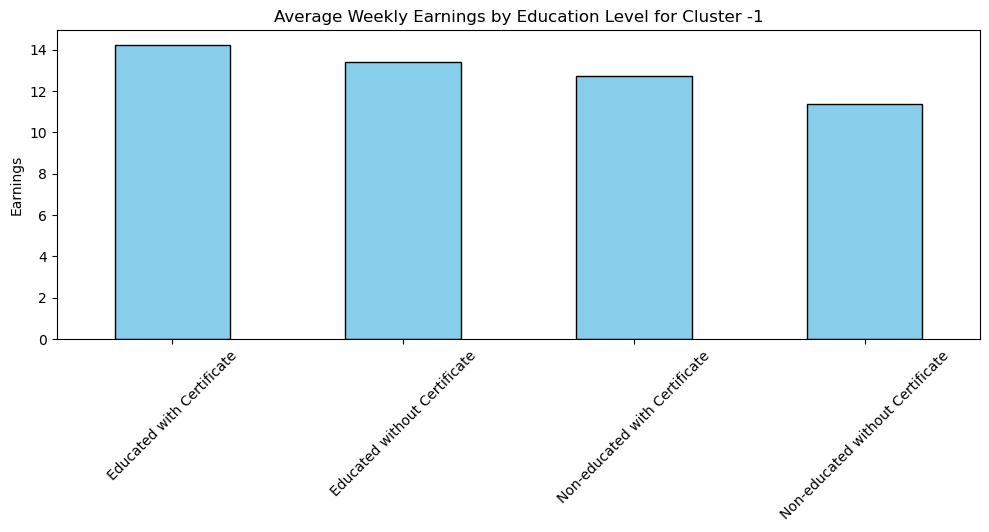

<Figure size 1000x600 with 0 Axes>

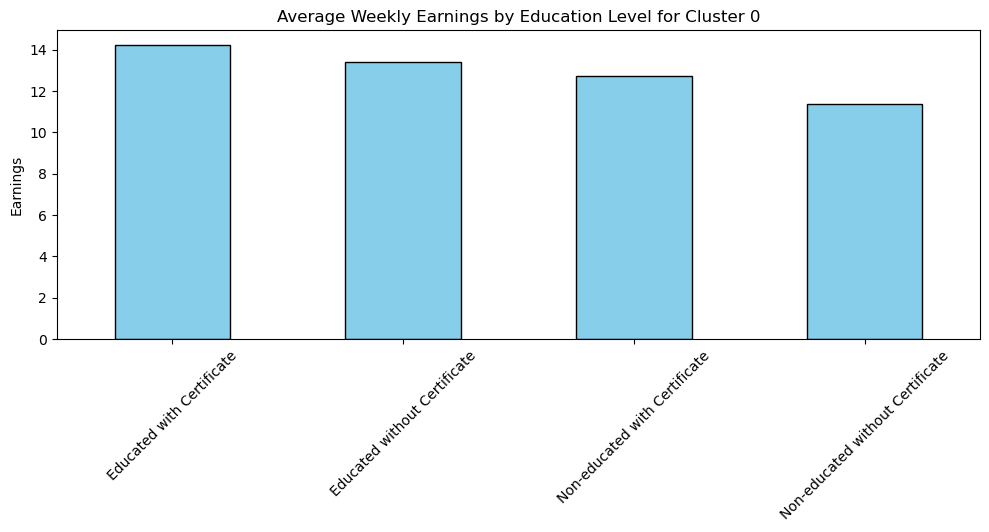

<Figure size 1000x600 with 0 Axes>

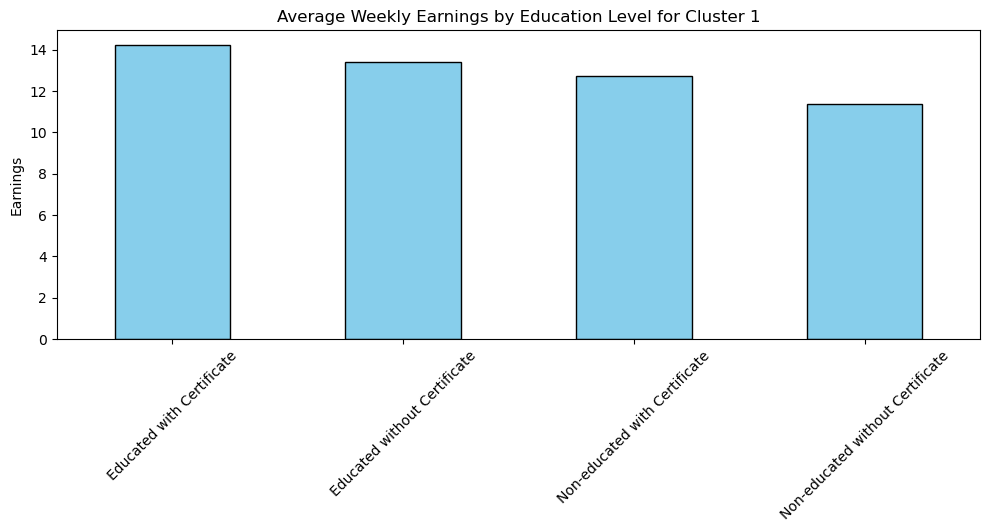

<Figure size 1000x600 with 0 Axes>

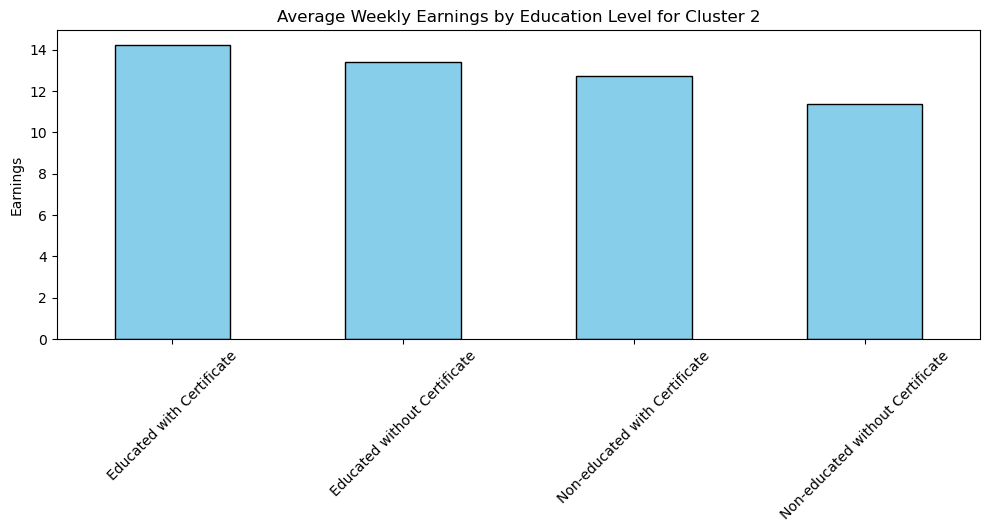

<Figure size 1000x600 with 0 Axes>

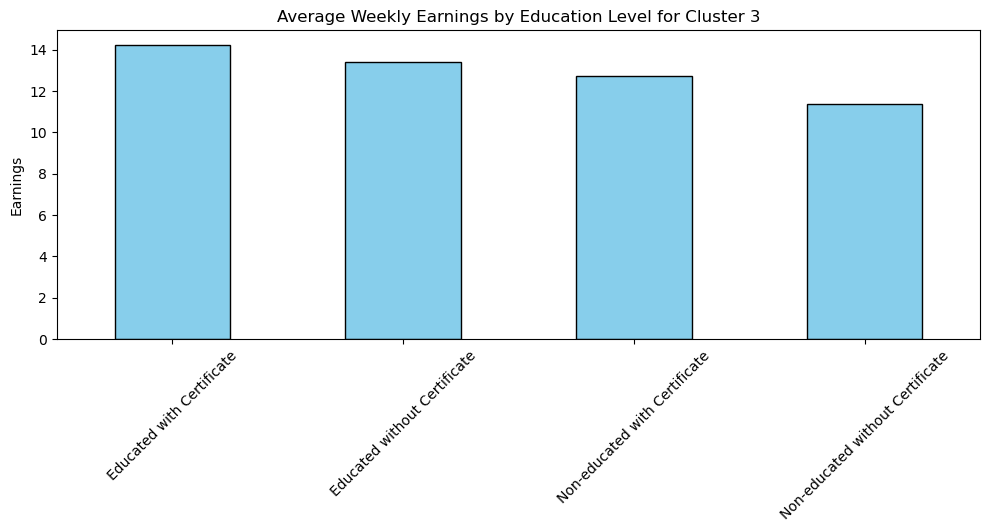

<Figure size 1000x600 with 0 Axes>

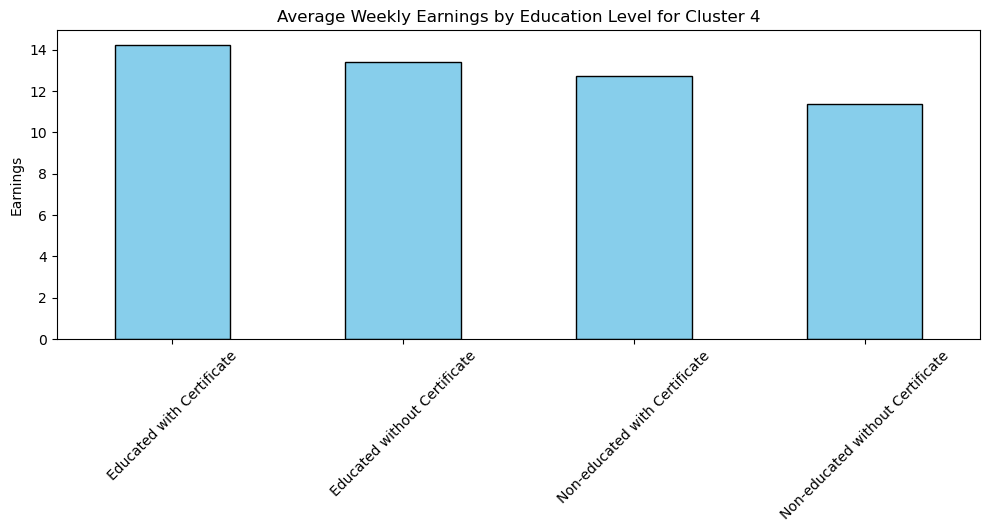

<Figure size 1000x600 with 0 Axes>

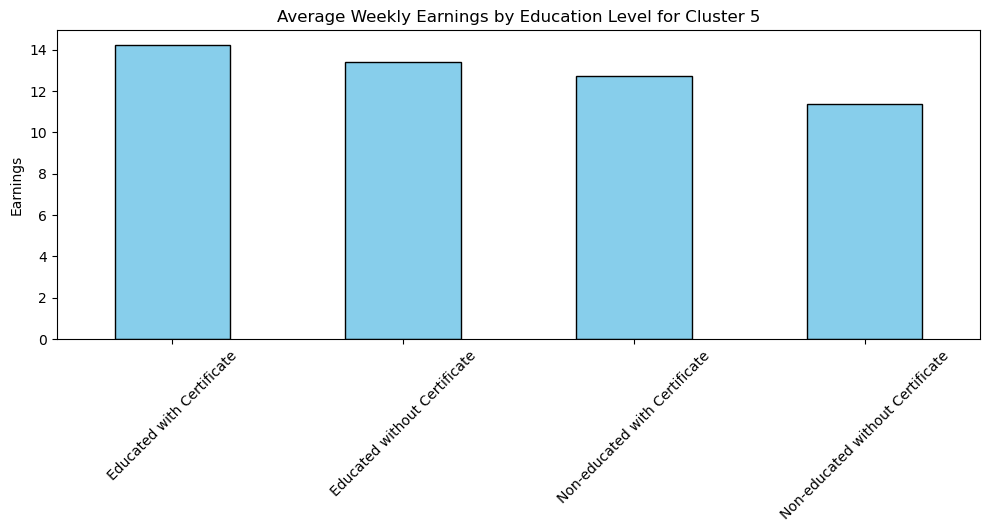

<Figure size 1000x600 with 0 Axes>

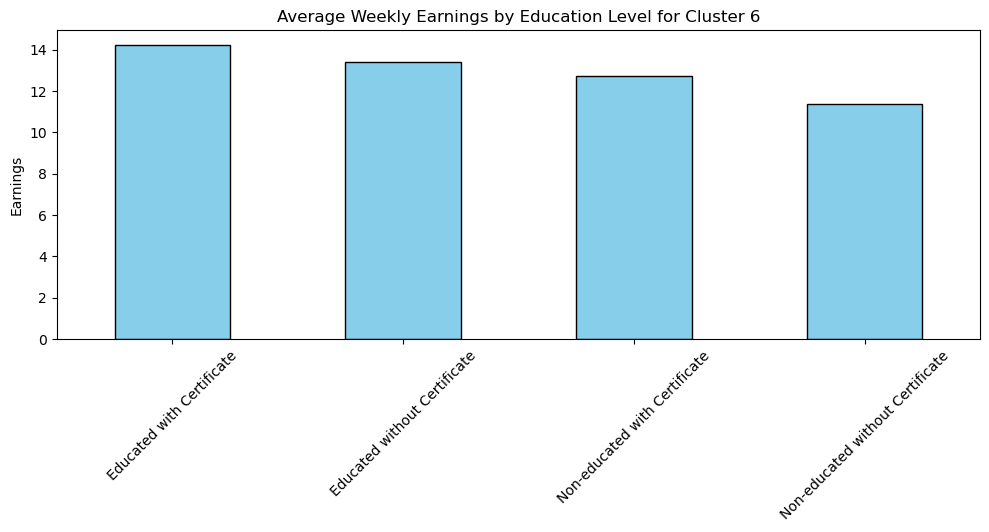

In [107]:
# Visualization 4: Distribution of income by Education Level
education_threshold = 41  # Threshold for considering someone as educated
certificate_col = 'professional_certification1'  

# Ensure 'education_level' and 'professional_certification1' are in a suitable format
vis_data['education_level_numeric'] = pd.to_numeric(vis_data['education_level'], errors='coerce')

# Define the four groups
conditions = [
    (vis_data['education_level_numeric'] < education_threshold) & (vis_data[certificate_col] == 1),
    (vis_data['education_level_numeric'] < education_threshold) & (vis_data[certificate_col] != 1),
    (vis_data['education_level_numeric'] >= education_threshold) & (vis_data[certificate_col] == 1),
    (vis_data['education_level_numeric'] >= education_threshold) & (vis_data[certificate_col] != 1)
]

choices = [
    'Non-educated with Certificate',
    'Non-educated without Certificate',
    'Educated with Certificate',
    'Educated without Certificate'
]

vis_data['Education_Certificate_Group'] = np.select(conditions, choices, default='Unknown')
# Creating a bar plot for the aggregated education levels
clusters = vis_data['Cluster_Labels'].unique()
for cluster in sorted(clusters):
    plt.figure(figsize=(10, 6))
    cluster_data = vis_data[data_reduced['Cluster_Labels'] == cluster]

    # Calculate average weekly earnings for each group
    grouped_earnings = vis_data.groupby('Education_Certificate_Group')['family_income'].mean()
    grouped_earnings = grouped_earnings.drop(columns=['Unknown'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    grouped_earnings.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Average Weekly Earnings by Education Level')
    plt.ylabel('Earnings')
    plt.title(f'Average Weekly Earnings by Education Level for Cluster {cluster}')
    plt.xlabel('')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
